<div id="toc"></div>

# The dataset

The dataset we are going to use in our examples is the [Iris flower dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), freely available from [UCLA](http://www.stat.ucla.edu/~kcli/stat216/data-folder-216/others/iris-data-fisher/iris-dat). It contains 150 examples, each being described by four fetures: sepal lenth, sepal width, petal length, petal width. The dataset is easily available through *sklearn* or *seaborn*. It can be used for both classification and clustering, as labels are available.

### Loading

In [1]:
from sklearn import datasets
import pandas as pd

iris = datasets.load_iris()

# load datapoints
x = pd.DataFrame(iris.data)
# name the different features/dimensions for clarity
x.columns = ['Sepal_Length','Sepal_Width','Petal_Length','Petal_Width']
# load labels/targets
y = pd.DataFrame(iris.target)
y.columns = ['Targets']

# how many examples and dimensions are in the dataset
print 'Dataset shape is: {}'.format(x.shape)

Dataset shape is: (150, 4)


In [27]:
# the number of examples for each class
print y['Targets'].value_counts()

2    50
1    50
0    50
Name: Targets, dtype: int64


### Visualising

A next logical step is to visualise the data. Most of the time this helps understanding the problem better. We will use the 'seaborn' package. by using *jointplot* let's plot each of the two pairs of features *Sepal_Length* and *Sepal_Width*,*Petal_Length* and *Petal_Width* their bivariate (inner image) and univariate (outer image) graphs.

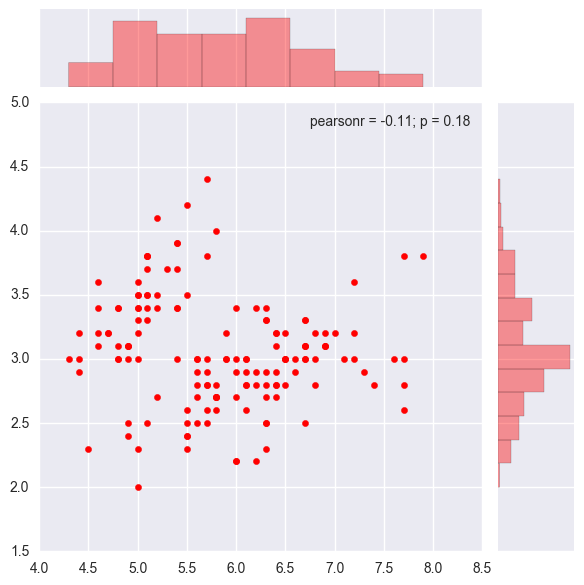

In [29]:
import seaborn as sns
sns.jointplot(x=x['Sepal_Length'].values, y=x['Sepal_Width'].values, color='r')
sns.plt.show()

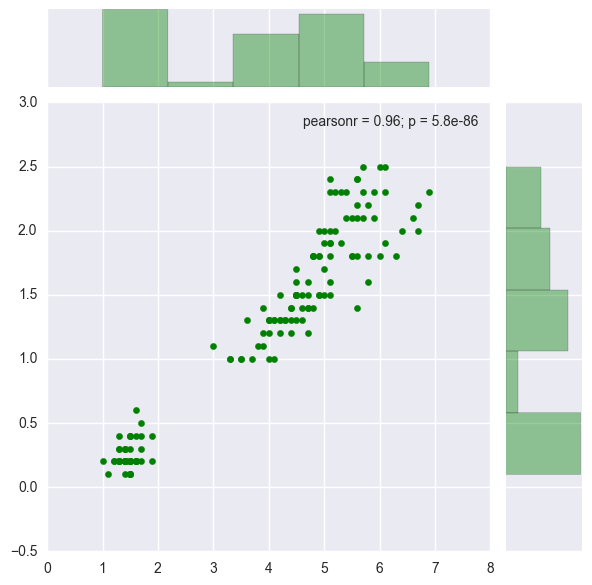

In [4]:
sns.jointplot(x=x['Petal_Length'].values, y=x['Petal_Width'].values, color='g')
sns.plt.show()

Seaborn has another interesting utility - *pairplot* that plots pairwise relationships in a dataset. By default, this function will create a grid of Axes such that each variable in data will by shared in the y-axis across a single row and in the x-axis across a single column. The diagonal Axes are treated differently, drawing a plot to show the univariate distribution of the data for the variable in that column.

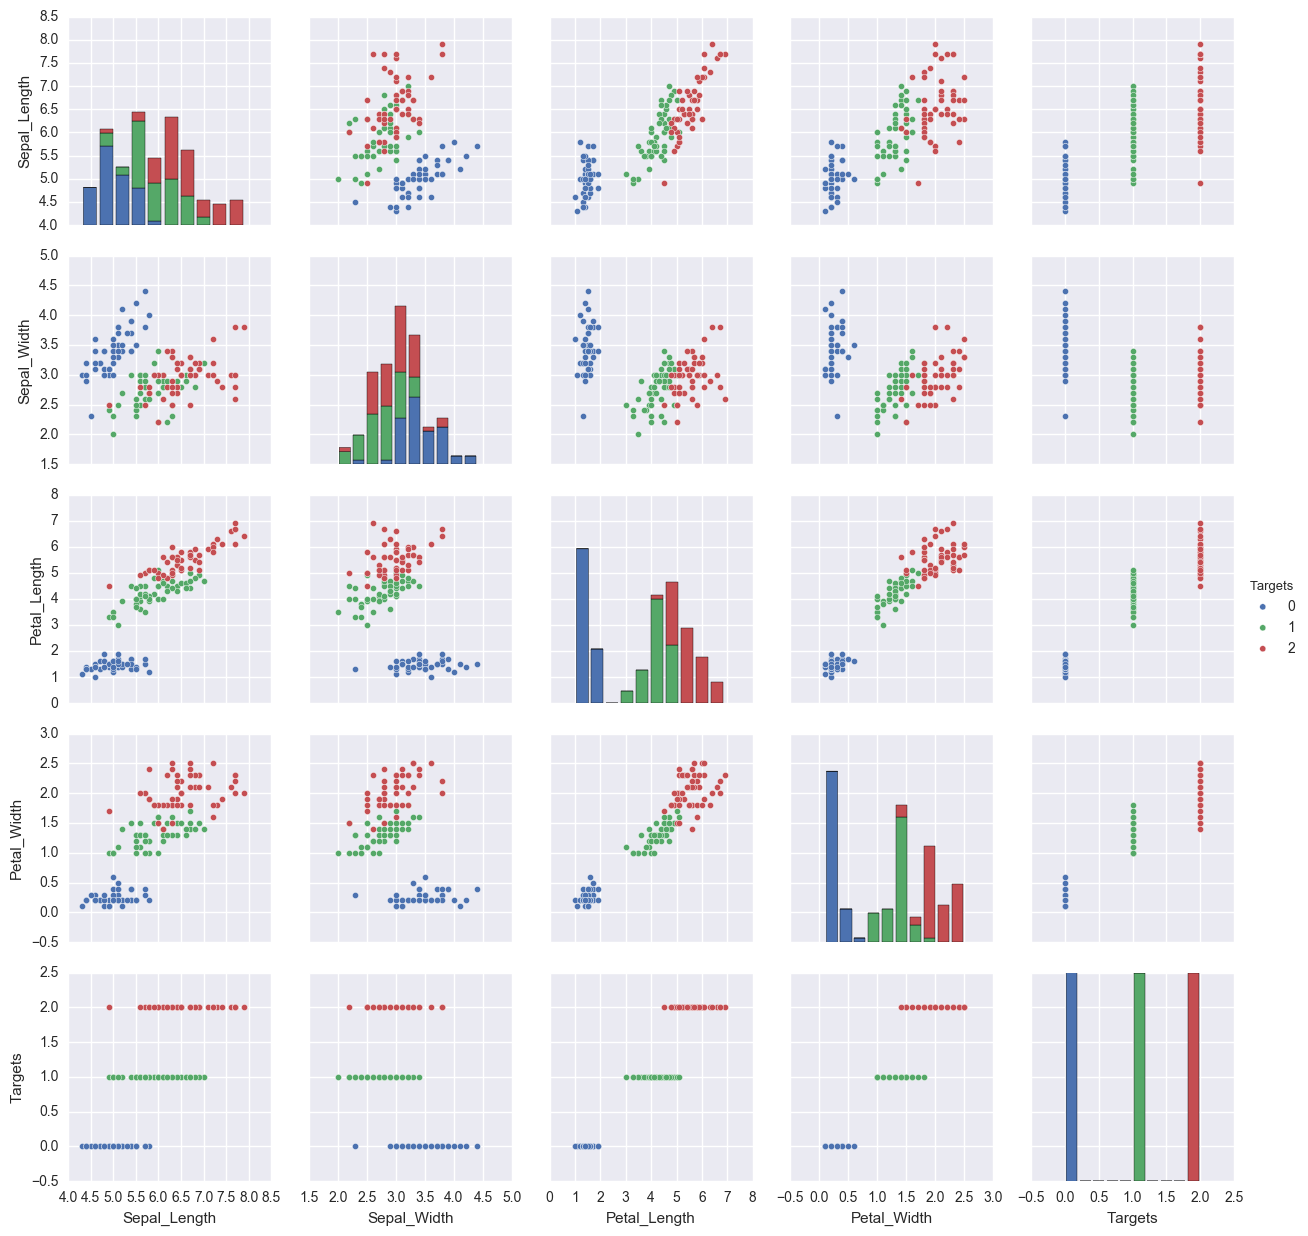

In [5]:
sns.pairplot(pd.concat([x, y], axis=1), hue="Targets")
sns.plt.show()

These visualisations are inspired by [Ben Hamner's](https://www.kaggle.com/benhamner/d/uciml/iris/python-data-visualizations) Kaggle notebook.

### Split in train / test

After the data is loaded, it needs to be split in training and test. For that purpose the `train_test_split(*arrays, **options)` function from sklearn is useful for creating random train and test subsets.

In [6]:
from sklearn import cross_validation
import numpy as np

X_train, X_test, y_train, y_test = cross_validation.train_test_split(x.values, y.values, \
                                                                     test_size=0.2, random_state=1)
 
# reformat train/test datasets for convenience
train = np.array(zip(X_train,y_train))
test = np.array(zip(X_test, y_test))

print 'Training has {} examples'.format(len(train))
print 'Testing has {} examples'.format(len(test))

Training has 120 examples
Testing has 30 examples


# K-Nearest Neighbours classification

### Using a high level library

It is much easier to use one of the already existing implementations of the algorithm of course, like the one from the *scikit-learn (sklearn)*. There are two main steps: training (called *fit*) and testing (called *predict*) - [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [7]:
# Train
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, metric='euclidean', n_jobs=4)
neigh.fit(X_train, y_train.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=4, n_neighbors=5, p=2,
           weights='uniform')

In [8]:
# Test
# Ensure our predictions is empty - avoid confusion. This is the final output
predictions = []
for i in range(len(X_test)):
    print 'Classifying test instance number ' + str(i) + ":",
    majority_vote = neigh.predict([X_test[i]])[0]
    predictions.append(majority_vote)
    print 'Predicted label=' + str(majority_vote) + ', Actual label=' + str(y_test[i][0])

Classifying test instance number 0: Predicted label=0, Actual label=0
Classifying test instance number 1: Predicted label=1, Actual label=1
Classifying test instance number 2: Predicted label=1, Actual label=1
Classifying test instance number 3: Predicted label=0, Actual label=0
Classifying test instance number 4: Predicted label=2, Actual label=2
Classifying test instance number 5: Predicted label=1, Actual label=1
Classifying test instance number 6: Predicted label=2, Actual label=2
Classifying test instance number 7: Predicted label=0, Actual label=0
Classifying test instance number 8: Predicted label=0, Actual label=0
Classifying test instance number 9: Predicted label=2, Actual label=2
Classifying test instance number 10: Predicted label=1, Actual label=1
Classifying test instance number 11: Predicted label=0, Actual label=0
Classifying test instance number 12: Predicted label=2, Actual label=2
Classifying test instance number 13: Predicted label=1, Actual label=1
Classifying test

And see a classification report. That computes precision, recall, f1-score and shows how many examples from the test were in each class.

In [9]:
from sklearn.metrics import classification_report, accuracy_score
# summarize performance of the classification
print '\nThe overall accuracy of the model is: ' + str(accuracy_score(y_test, predictions)) + "\n"
report = classification_report(y_test, predictions, target_names = iris.target_names)
print 'A detailed classification report: \n\n' + report


The overall accuracy of the model is: 1.0

A detailed classification report: 

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        11
 versicolor       1.00      1.00      1.00        13
  virginica       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00        30



### Not using a high level library

The main building block for deciding between the 3 classes of plants in the case of KNN is to compute the distance between examples. In this example we will use the Euclidean distance, however there are many others that might be useful. For example, the distance between two points *x* and *y* is given by ![](distance_euclidean_1.gif)

where *n* is the number of dimensions (four in the case of the iris dataset). 

We’ll use the zip function and list comprehension. The zip function aggregates elements from lists (or other iterables, like strings) to return a list of tuples, such that `zip([1,2,3], [4,5,6])` will return `[(1,4), (2,5), (3,6)]`.

In [10]:
import math

# This function computes the Euclide
def get_distance(data1, data2):
    points = zip(data1, data2)
    # this is something you will want to do in parallel for more complex datasets
    diffs_squared_distance = [pow(x - y, 2) for (x, y) in points]
    return math.sqrt(sum(diffs_squared_distance))

Let's use the function to compute, for example, the distance between the first two training points:

In [11]:
train[0][0], train[1][0]

(array([ 6.1,  3. ,  4.6,  1.4]), array([ 7.7,  3. ,  6.1,  2.3]))

In [12]:
get_distance(train[0][0], train[1][0])

2.37065391822594

By computing the distances between one example and all other examples in the dataset and sorting the results, we can obtain a list of the *"closest"* other examples - *the neighbours*.

In [13]:
from operator import itemgetter
 
def get_neighbours(training_set, test_instance, k):
    distances = [(training_instance, get_distance(test_instance[0], training_instance[0])) for training_instance in training_set]
    # index 1 is the calculated distance between training_instance and test_instance
    sorted_distances = sorted(distances, key=itemgetter(1))
    # extract only training instances
    sorted_training_instances = [tuple[0] for tuple in sorted_distances]
    # select first k elements
    return sorted_training_instances[:k]

Using the nearest neighbours you just identified, you can get a prediction for the class of the test instance by majority voting – simply tally up which class comes up the most often among the nearest neighbours.

In [14]:
from collections import Counter

def get_majority_vote(neighbours):
    # index 1 is the class
    classes = [neighbour[1] for neighbour in neighbours]
    count = Counter([cl[0] for cl in classes])
    return count.most_common()[0][0] 

Finally, we create the classification report.

In [15]:
# generate predictions
predictions = []

# let's arbitrarily set k equal to 5, meaning that to predict the class of new instances,
k = 5

# for each instance in the test set, get nearest neighbours and majority vote on predicted class
for i in range(len(X_test)):
    print 'Classifying test instance number ' + str(i) + ":",
    neighbours = get_neighbours(training_set=train, test_instance=test[i], k=k)
    majority_vote = get_majority_vote(neighbours)
    predictions.append(majority_vote)
    print 'Predicted label=' + str(majority_vote) + ', Actual label=' + str(test[i][1][0])

Classifying test instance number 0: Predicted label=0, Actual label=0
Classifying test instance number 1: Predicted label=1, Actual label=1
Classifying test instance number 2: Predicted label=1, Actual label=1
Classifying test instance number 3: Predicted label=0, Actual label=0
Classifying test instance number 4: Predicted label=2, Actual label=2
Classifying test instance number 5: Predicted label=1, Actual label=1
Classifying test instance number 6: Predicted label=2, Actual label=2
Classifying test instance number 7: Predicted label=0, Actual label=0
Classifying test instance number 8: Predicted label=0, Actual label=0
Classifying test instance number 9: Predicted label=2, Actual label=2
Classifying test instance number 10: Predicted label=1, Actual label=1
Classifying test instance number 11: Predicted label=0, Actual label=0
Classifying test instance number 12: Predicted label=2, Actual label=2
Classifying test instance number 13: Predicted label=1, Actual label=1
Classifying test

In [16]:
from sklearn.metrics import classification_report, accuracy_score
# summarize performance of the classification
print '\nThe overall accuracy of the model is: ' + str(accuracy_score(y_test, predictions)) + "\n"
report = classification_report(y_test, predictions, target_names = iris.target_names)
print 'A detailed classification report: \n\n' + report


The overall accuracy of the model is: 1.0

A detailed classification report: 

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        11
 versicolor       1.00      1.00      1.00        13
  virginica       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00        30



# K-means clustering

The difference between K-means and KNN is that one is unsupervised, while the other one is supervised. K-means is case of clustering with centroid methods, so it is necessary to input the (exact) number of desired final clusters.

In [17]:
n_clusters=3

Ar every iteration, the center of the cluster moves slightly to minimize the objective function.

We'll use [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from *sklearn*.

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, n_jobs=4)
y['Results_kmeans'] = kmeans.fit_predict(x.values)

Again, in this case it is interesting to see how the results look. First step is to create a colormap - that is needed in order to color each class with a different color

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(0,n_clusters,n_clusters+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

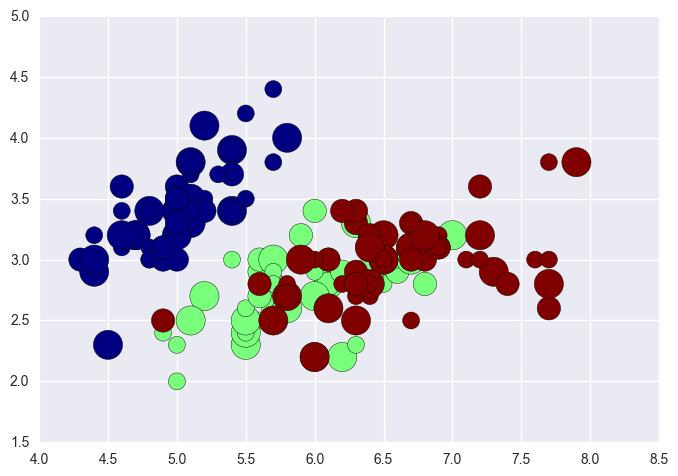

In [20]:
# plot the initial Sepal length and width in color separating between classes
plt.scatter(x['Sepal_Length'].values, x['Sepal_Width'].values, c=y['Targets'].values, \
            s=np.random.randint(100,500,n_clusters), cmap=cmap,norm=norm)
plt.show()

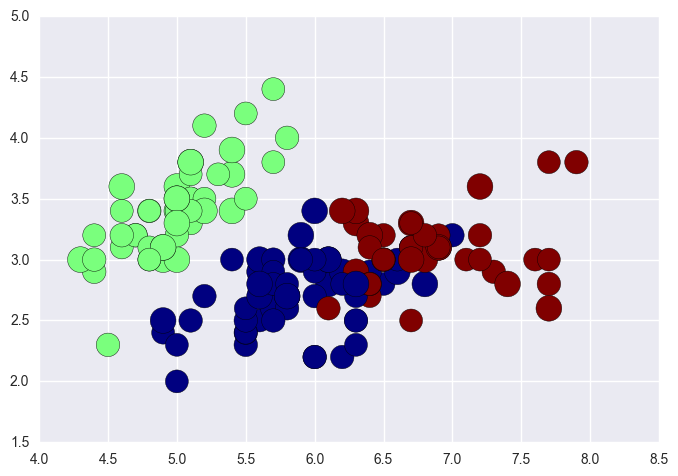

In [21]:
# plot our own K-means results
plt.scatter(x['Sepal_Length'].values, x['Sepal_Width'].values, c=y['Results_kmeans'].values, \
            s=np.random.randint(100, 500, n_clusters), cmap=cmap, norm=norm)
plt.show()

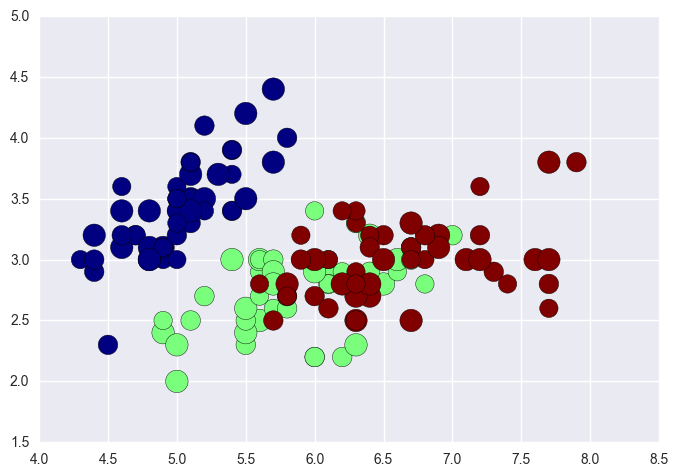

In [22]:
y['Results_knn'] = neigh.predict(x.values)
# plot our own KNN results
plt.scatter(x['Sepal_Length'].values, x['Sepal_Width'].values, c=y['Results_knn'].values, \
            s=np.random.randint(100, 500, n_clusters), cmap=cmap, norm=norm)
plt.show()

# Learning Vector Quantization (LVQ)

Once we have our centroids, we just need to *quantize* each cluster. The previously computed K-means clusters can be used as a starting point for vector quantization. The `kmeans.cluster_centers_` are called *codebooks* (plotted with diamonds).

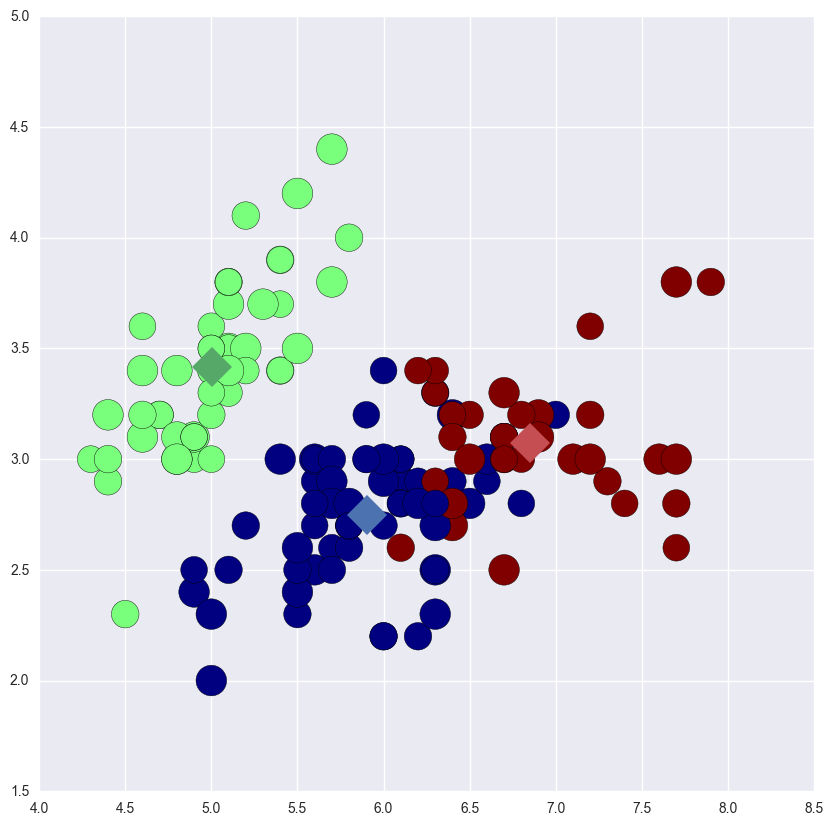

In [23]:
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
ax1.scatter(x['Sepal_Length'].values, x['Sepal_Width'].values, c=y['Results_kmeans'].values, \
            s=np.random.randint(100, 500, n_clusters), cmap=cmap, norm=norm)
for cent in kmeans.cluster_centers_:
    ax1.plot(cent[0], cent[1], 'D', markersize=20)
plt.show()

In [24]:
from scipy.cluster.vq import vq

codebook = kmeans.cluster_centers_
while True:
    results = vq(x.values, codebook)
    y['Results_lvq'] = results[0]
    if min(results[1]) < 0.6:
        break

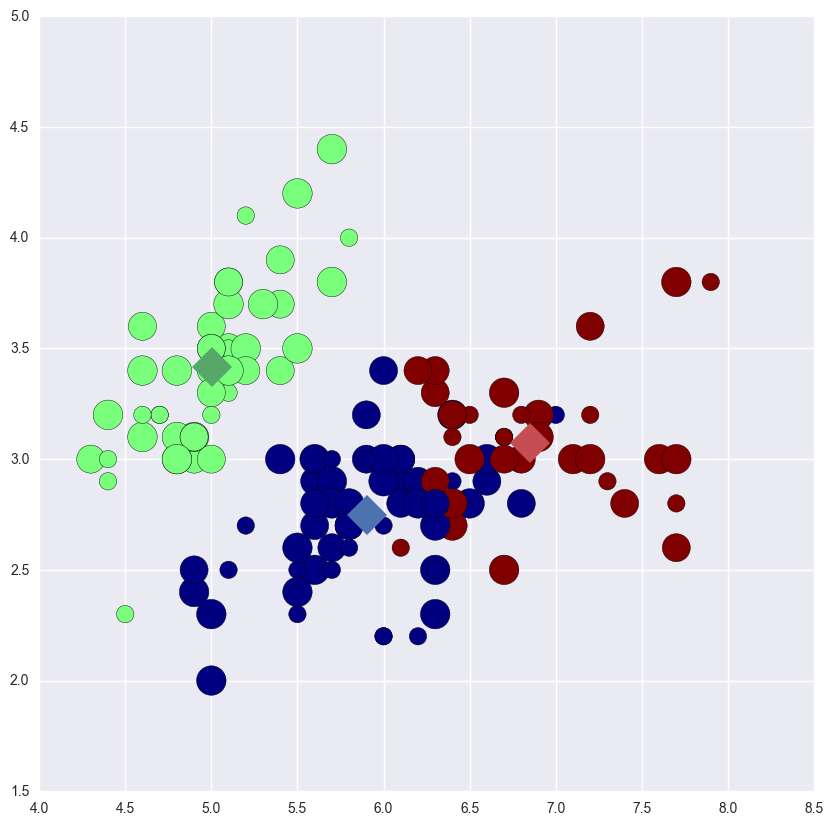

In [25]:
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
ax1.scatter(x['Sepal_Length'].values, x['Sepal_Width'].values, c=y['Results_lvq'].values, \
            s=np.random.randint(100, 500, n_clusters), cmap=cmap, norm=norm)
for cent in kmeans.cluster_centers_:
    ax1.plot(cent[0], cent[1], 'D', markersize=20)
plt.show()

In [26]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>